In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
import h5py

plt.rc('figure', figsize=(6,4))
plt.rc('font', size=11)
plt.style.use('dark_background')
# plt.rc('figure',facecolor=(0,0,0,0)) # Set transparent background
%config InlineBackend.figure_format='retina'

In [2]:
import quflow as qf

#qf.gpu.check_status()

2023-07-02 01:43:45.015103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [49]:
N = 200 # Size of matrices
lmax = 10  # How many spherical harmonics (SH) coefficients to include
np.random.seed(42)  # For reproducability
omega0 = np.random.randn(lmax**2)  # Array with SH coefficients
W0 = qf.shr2mat(omega0, N=N)  # Convert SH coefficients to matrix

filename_cpu = "cpu_test_sim_N_{}.hdf5".format(str(N))
filename_gpu = "gpu_test_sim_N_{}.hdf5".format(str(N))
time = 6.0 # in second
inner_time = 0.25 # in seconds
qstepsize = 0.2 # in qtime

# Run this if you want to remove the existing hdf5 file
#%rm $filename_cpu
#%rm $filename_gpu

dt = qf.qtime2seconds(qstepsize, N)
print("The physical stepsize is {:.3e} seconds.".format(dt))
print("{} steps per output, in total {} steps.".format(round(inner_time/dt), round(time/dt)))

The physical stepsize is 5.013e-04 seconds.
499 steps per output, in total 11968 steps.


In [27]:
"""
CPU 
"""
# Callback data object
mysim_cpu = qf.QuData(filename_cpu)

# Save initial conditions if file does not exist already, otherwise load from last step
try:
    f = h5py.File(filename_cpu, "r")
except IOError or KeyError:
    W = W0.copy()
    mysim_cpu(W, 0.0)
else:
    W = qf.shr2mat(f['state'][-1,:], N=N)
    assert W.shape[0] == N, "Looks like the saved data use N = {} whereas you specified N = {}.".format(W.shape[0], N)
    f.close()

# Select solver
method = qf.isomp_fixedpoint
method_kwargs = {"hamiltonian": qf.solve_poisson, "verbatim":False, "maxit":7, "tol":1e-12}

# Run simulation

qf.solve(W, qstepsize=qstepsize, time=time, inner_time=inner_time, callback=mysim_cpu,
         method=method, method_kwargs=method_kwargs)

# Flush cache data
mysim_cpu.flush()

100%|██████████| 11968/11968 [20:36<00:00,  9.68 steps/s]


In [28]:

"""
GPU
"""

# Callback data object
mysim_gpu = qf.QuData(filename_gpu)

# Save initial conditions if file does not exist already, otherwise load from last step
try:
    f = h5py.File(filename_gpu, "r")
except IOError or KeyError:
    W = W0.copy()
    mysim_gpu(W, 0.0)
else:
    W = qf.shr2mat(f['state'][-1,:], N=N)
    assert W.shape[0] == N, "Looks like the saved data use N = {} whereas you specified N = {}.".format(W.shape[0], N)
    f.close()

# Select solver
# The cupy based isomp solver and poisson solver needs to be initialized 
method = qf.gpu.gpu_core.isomp_gpu_skewherm_solver(W0)
ham = qf.gpu.gpu_core.solve_poisson_interleaved_cp(N)

# Method kwargs are the same, since we still use the same qf.solve from dynamics.py
method_kwargs = {"hamiltonian": ham.solve_poisson, "verbatim":False, "maxit":7, "tol":1e-12}

# Run simulation
# Run simulation


qf.solve(W, qstepsize=qstepsize, time=time, inner_time=inner_time, callback=mysim_gpu,
         method=method.solve_step, method_kwargs=method_kwargs)

# Flush cache data
mysim_gpu.flush()

100%|██████████| 11968/11968 [04:34<00:00, 43.63 steps/s]


<Figure size 640x480 with 0 Axes>

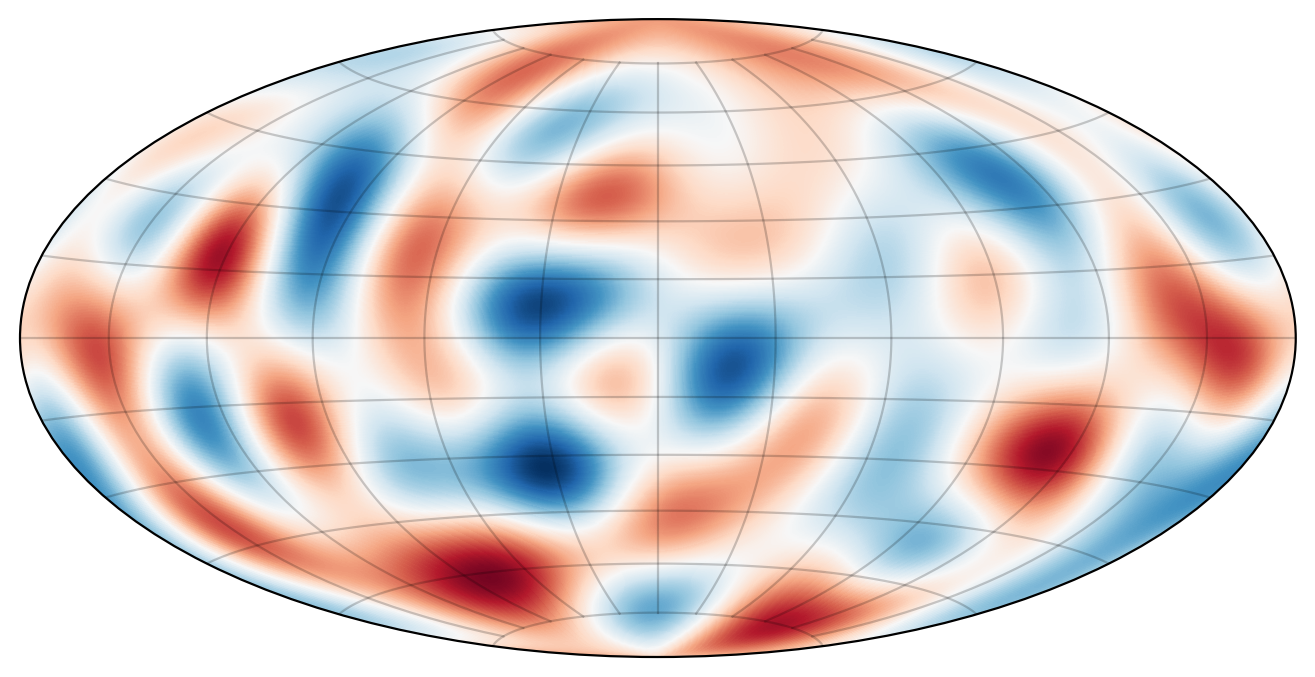

<Figure size 640x480 with 0 Axes>

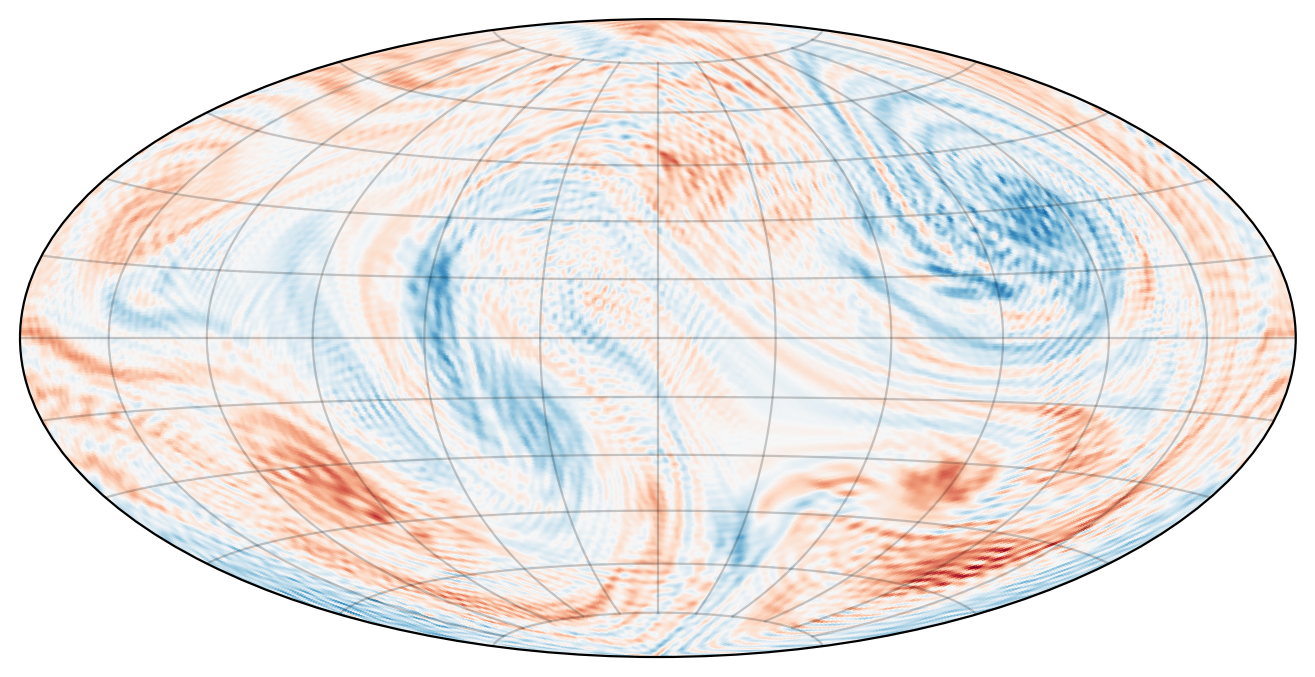

<Figure size 640x480 with 0 Axes>

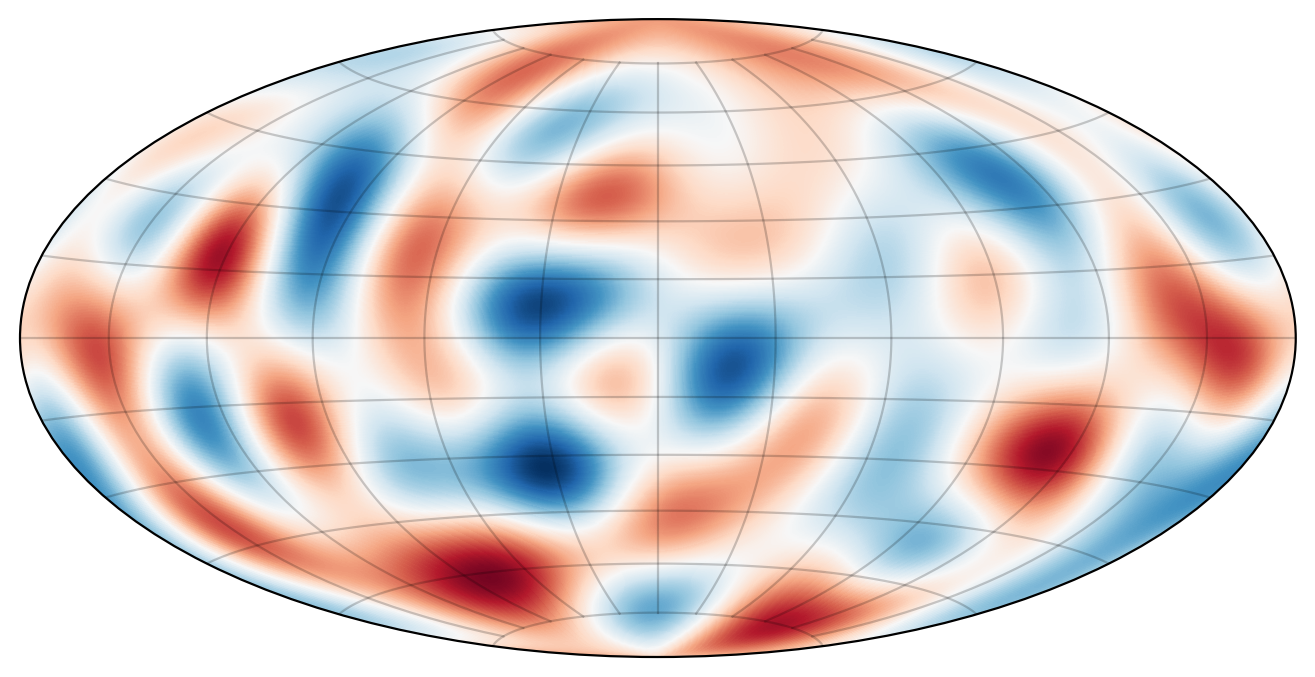

<Figure size 640x480 with 0 Axes>

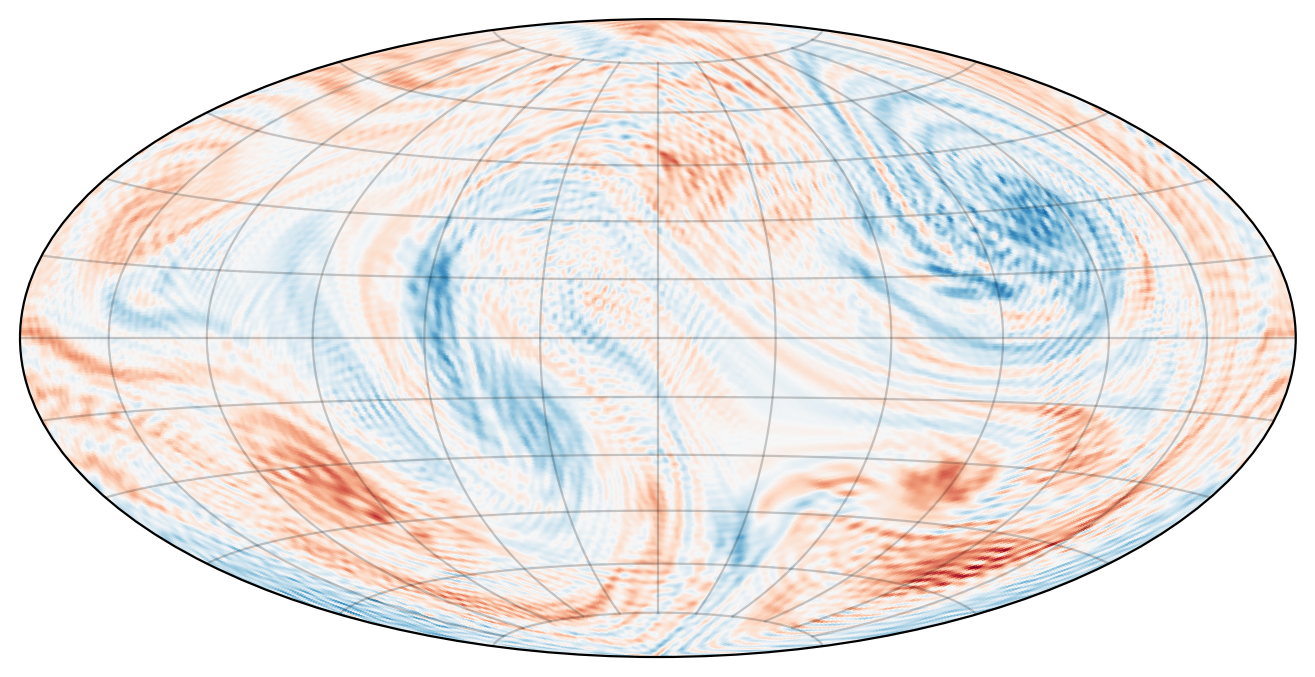

In [29]:
# Plot last state
with h5py.File(filename_gpu, 'r') as data:

    omega_first = data['state'][0]
    plt.figure()
    qf.plot2(omega_first, projection='hammer', N=600)
    #plt.tight_layout()
    plt.savefig(f"gpu_{N}_first_state.pdf", bbox_inches='tight')

    omega = data['state'][-1]
    plt.figure()
    qf.plot2(omega, projection='hammer', N=600)
    #plt.tight_layout()
    plt.savefig(f"gpu_{N}_last_state.pdf", bbox_inches='tight')

# Plot last state
with h5py.File(filename_cpu, 'r') as data:

    omega_first = data['state'][0]
    plt.figure()
    qf.plot2(omega_first, projection='hammer', N=600)
    #plt.tight_layout()
    plt.savefig(f"cpu_{N}_first_state.pdf", bbox_inches='tight')

    omega = data['state'][-1]
    plt.figure()
    qf.plot2(omega, projection='hammer', N=600)
    #plt.tight_layout()
    plt.savefig(f"cpu_{N}_last_state.pdf", bbox_inches='tight')

In [51]:
with h5py.File(filename_gpu, 'r') as data:
    anim = qf.create_animation2(filename_gpu.replace(".hdf5",".mp4"), data['state'], projection='mollweide', N=256)
anim

100%|██████████| 25/25 [00:06<00:00,  3.70 frames/s]


## Compare GPU solution to CPU

[0.00000000e+00 2.27539939e-10 4.65311291e-10 7.22057834e-10
 1.02178443e-09 1.38780234e-09 1.84851048e-09 2.44599831e-09
 3.20923021e-09 4.15272264e-09 5.27689482e-09 6.56869949e-09
 8.01790928e-09 9.58801637e-09 1.12227732e-08 1.28798176e-08
 1.45111216e-08 1.61495164e-08 1.78181073e-08 1.95673728e-08
 2.14044138e-08 2.33163745e-08 2.53098555e-08 2.74617251e-08
 2.98018068e-08]


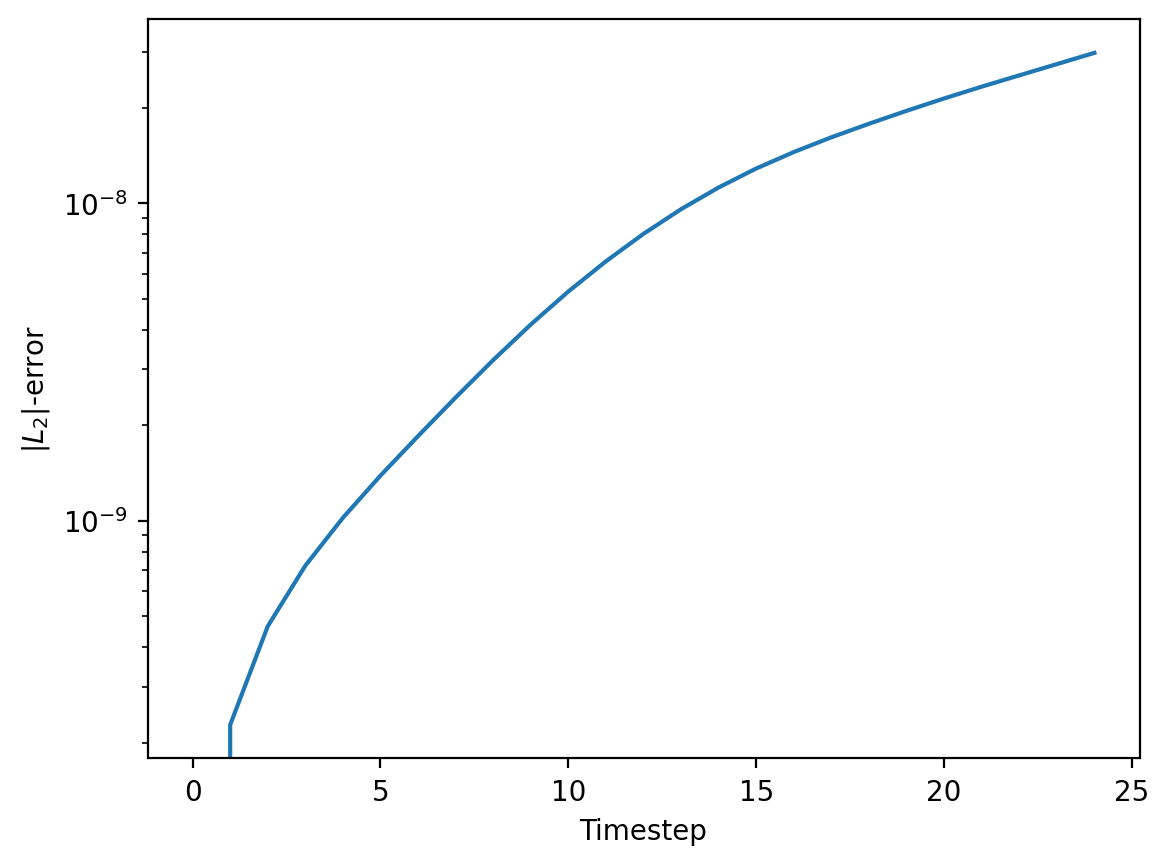

In [52]:
plt.style.use('default')

fig,ax = plt.subplots()
with h5py.File(filename_gpu, 'r') as data_gpu, h5py.File(filename_cpu, 'r') as data_cpu:
    diff = np.zeros(data_gpu['state'].shape[0])
    for k in range(data_gpu['state'].shape[0]):
        diff[k] = np.linalg.norm(data_cpu['state'][k]-data_gpu['state'][k])
    print(diff)
    ax.plot(diff)
    ax.set_yscale("log")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("$|L_2|$-error")
    fig.savefig(f"error_{N}.pdf")

## Check conservation of casimirs


25


25
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.84217094e-14 0.00000000e+00 2.84217094e-14 2.84217094e-14
 4.26325641e-14 2.84217094e-14 2.84217094e-14 2.84217094e-14
 4.26325641e-14 2.84217094e-14 2.84217094e-14 7.10542736e-14
 2.84217094e-14 0.00000000e+00 2.84217094e-14 4.26325641e-14
 2.84217094e-14 2.84217094e-14 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


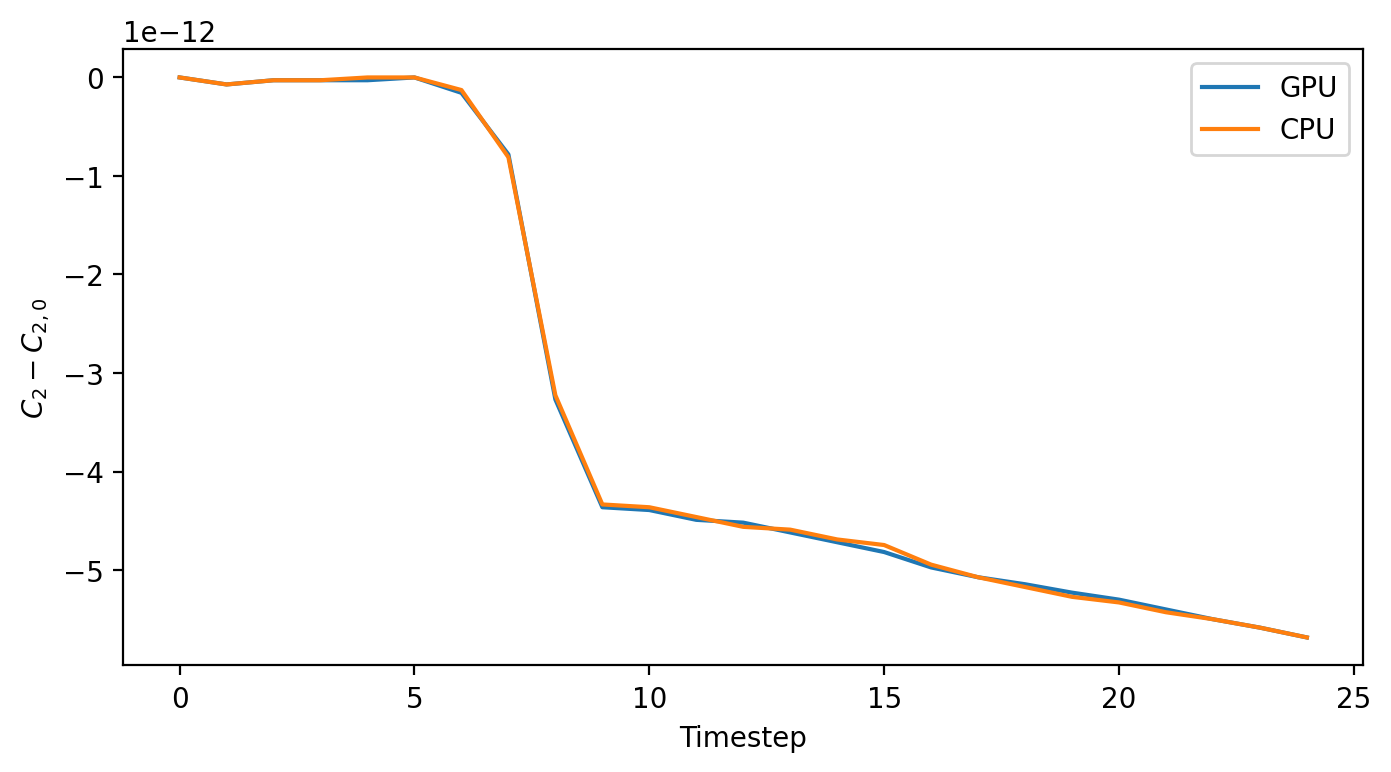

In [57]:
# Check conservation of casimirs

casimir_gpu = []
casimir_cpu = []

fig,ax = plt.subplots(1,figsize = (8,4))

#plt.ticklabel_format(useOffset=False)
with h5py.File(filename_gpu, 'r') as data:
    print(data['state'].shape[0])
    for k in range(data['state'].shape[0]):
        omega = data['state'][k]
        casimir_gpu += [np.linalg.norm(omega)**2]
    casimir_gpu = np.asarray(casimir_gpu)
    ax.plot(casimir_gpu-casimir_gpu[0], label="GPU")

with h5py.File(filename_cpu, 'r') as data:
    print(data['state'].shape[0])
    for k in range(data['state'].shape[0]): 
        omega = data['state'][k] # type: ignore
        casimir_cpu += [np.linalg.norm(omega)**2]
    casimir_cpu = np.asarray(casimir_cpu)
    ax.plot(casimir_cpu-casimir_cpu[0], label="CPU")

#ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.set_ylabel("$C_2 - C_{2,0}$")
ax.set_xlabel("Timestep")
ax.legend()
fig.savefig(f"gpu_cpu_{N}_casimir_2.pdf")
#plt.show()

print(np.abs(casimir_gpu-casimir_cpu))

25


25
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.77635684e-15 0.00000000e+00 1.77635684e-15 1.77635684e-15
 1.77635684e-15 1.77635684e-15 1.77635684e-15 1.77635684e-15
 1.77635684e-15 1.77635684e-15 1.77635684e-15 3.55271368e-15
 1.77635684e-15 0.00000000e+00 1.77635684e-15 1.77635684e-15
 1.77635684e-15 1.77635684e-15 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


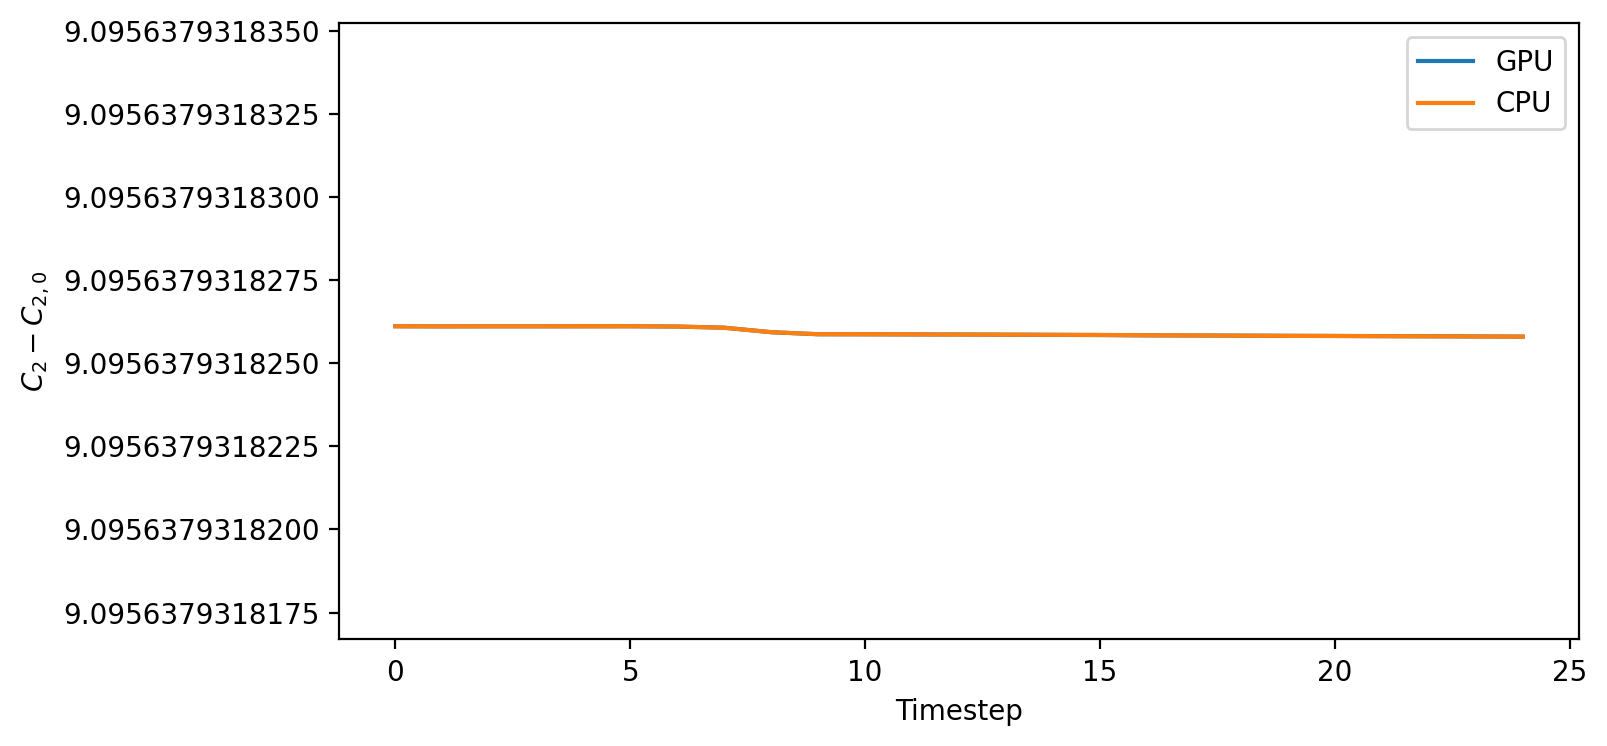

In [60]:
# Check conservation of casimirs

casimir_gpu = []
casimir_cpu = []

fig,ax = plt.subplots(1,figsize = (8,4))

#plt.ticklabel_format(useOffset=False)
with h5py.File(filename_gpu, 'r') as data:
    print(data['state'].shape[0])
    for k in range(data['state'].shape[0]):
        omega = data['state'][k]
        casimir_gpu += np.trace(qf.shr2mat(omega,N=N))
    casimir_gpu = np.asarray(casimir_gpu)
    ax.plot(casimir_gpu, label="GPU")

with h5py.File(filename_cpu, 'r') as data:
    print(data['state'].shape[0])
    for k in range(data['state'].shape[0]): 
        omega = data['state'][k] # type: ignore
        casimir_cpu += omega[0]*np.sqrt(4*np.pi)
    casimir_cpu = np.asarray(casimir_cpu)
    ax.plot(casimir_cpu, label="CPU")

#ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.set_ylabel("$C_2 - C_{2,0}$")
ax.set_xlabel("Timestep")
ax.legend()
fig.savefig(f"gpu_cpu_{N}_casimir_1.pdf")
#plt.show()

print(np.abs(casimir_gpu-casimir_cpu))